In [18]:
import re
import numpy as np
from pprint import pprint
import random
import time
import sys
from alive_progress import alive_bar
import copy
import csv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,
    roc_curve, auc, matthews_corrcoef
)

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 2080 Ti


In [3]:
NGRAM_SIZE = 4
ngramDicts = {}

MODEL = 1

In [4]:
# Tokenize the input text and returns a list of tokens
def get_token_list(text: str) -> list:
    # lower case it
    text = text.lower()
    # tokenize hashtags
    text = re.sub(r"#(\w+)", r"<HASHTAG> ", text)
    text = re.sub(r'\d+(,(\d+))*(\.(\d+))?%?\s', '<NUMBER> ', text)
    # tokenize mentions
    text = re.sub(r"@(\w+)", r"<MENTION> ", text)
    # tokenize urls
    text = re.sub(r"http\S+", r"<URL> ", text)
    # starting with www
    text = re.sub(r"www\S+", r"<URL> ", text)

    special_chars = [' ', '*', '!', '?', '.', ',', ';', ':', '(', ')', '[', ']', '{', '}', '/', '\\', '|', '-', '_', '—','=','+', '`', '~', '@', '#', '$', '%', '^', '&', '0', '1', '2', '3', '4', '5', '6', '7', '8','9']
    # pad the special characters with spaces
    for char in special_chars:
        text = text.replace(char, ' ')
    # pad < and > with spaces
    text = text.replace('<', ' <')
    text = text.replace('>', '> ')

    return text.split()
# slipts the text into sentences and tokenizes them. 
def sentence_tokenizer(fullText: str, thresh: int) -> list:
    # lower case it
    fullText = fullText.lower()
  
    sentenceEnders = ['.', '!', '?']
    # split on sentence enders handling cases such as Mr. etc
    fullText = fullText.replace('mr.', 'mr')
    fullText = fullText.replace('mrs.', 'mrs')
    fullText = fullText.replace('dr.', 'dr')
    fullText = fullText.replace('st.', 'st')
    fullText = fullText.replace('co.', 'co')
    fullText = fullText.replace('inc.', 'inc')
    fullText = fullText.replace('e.g.', 'eg')
    fullText = fullText.replace('i.e.', 'ie')
    fullText = fullText.replace('etc.', 'etc')
    fullText = fullText.replace('vs.', 'vs')
    fullText = fullText.replace('u.s.', 'us')

    sentences = re.split(r' *[\.\?!][\'"\)\]]* *', fullText)

    sentences = [s.replace('\n', ' ') for s in sentences]
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if s != '']
    sentences = [get_token_list(s) for s in sentences]

    tokenDict = {}
    for sentence in sentences:
        for token in sentence:
            if token in tokenDict:
                tokenDict[token] += 1
            else:
                tokenDict[token] = 1

    for sentence in sentences:
        for i in range(len(sentence)):
            if tokenDict[sentence[i]] <= thresh:
                sentence[i] = '<unk>'

    return sentences

# replaces all tokens with frequency less than threshold with <unk>
def rem_low_freq(tokens: list, threshold: int) -> list:
    # get the frequency of each token
    freq = {}
    for token in tokens:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

    # remove tokens with frequency less than threshold
    for token in list(freq.keys()):
        if freq[token] <= threshold:
            del freq[token]

    # replace all tokens not in freq with <unk>
    for i in range(len(tokens)):
        if tokens[i] not in freq:
            tokens[i] = '<unk>'

    return tokens

# constructs an n-gram dictionary from the input token list
def construct_ngram(n: int, token_list: list) -> dict:
    ngram_dict = {}
    for i in range(len(token_list) - n + 1):
        ngram_to_check = token_list[i:i + n]
        cur_dict = ngram_dict
        for j in range(n):
            if ngram_to_check[j] not in cur_dict:
                if j == n - 1:
                    cur_dict[ngram_to_check[j]] = 1
                else:
                    cur_dict[ngram_to_check[j]] = {}
            else:
                if j == n - 1:
                    cur_dict[ngram_to_check[j]] += 1
            cur_dict = cur_dict[ngram_to_check[j]]

    return ngram_dict
# counts the number of n-grams in the input n-gram dictionary using dfs
def dfs_count(ngram_dict: dict) -> int:
    count = 0
    for key, value in ngram_dict.items():
        if isinstance(value, dict):
            count += dfs_count(value)
        else:
            count += 1
    return count

# gives the count of the input n-gram
def ngram_count(ngram_dict: dict, ngram: list) -> int:
    cur_dict = ngram_dict[len(ngram)]
    if len(ngram) == 1:
        if ngram[0] in cur_dict:
            return cur_dict[ngram[0]]
        else:
            return cur_dict['<unk>']
    for i in range(len(ngram)):
        if ngram[i] in cur_dict:
            cur_dict = cur_dict[ngram[i]]
        else:
            return 0
    return cur_dict

In [5]:
dfs_countD = {}

def kneser_ney_smoothing(ngram_dict: dict, d: float, ngram: list) -> float:
    # Replace unknown tokens in ngram with '<unk>'
    ngram = ['<unk>' if token not in ngram_dict[1] else token.lower() for token in ngram]

    if len(ngram) == 1:
        # If unigram, compute probability directly
        denom = dfs_countD.get(2, dfs_count(ngram_dict[2]))
        count = sum(1 for value in ngram_dict[2].values() if ngram[-1] in value)
        return count/denom

    deno = ngram_count(ngram_dict, ngram[:-1])
    if(deno == 0):
        return 0
    else:
        first = max(ngram_count(ngram_dict, ngram) - d, 0) / deno
    
    try:
        cur_dict = ngram_dict[len(ngram)]
        for token in ngram[:-1]:
            cur_dict = cur_dict[token]
        second_rhs = len(cur_dict)
    except KeyError:
        second_rhs = 0
    
    second = d * second_rhs / ngram_count(ngram_dict, ngram[:-1])
    
    return first + second * kneser_ney_smoothing(ngram_dict, d, ngram[1:])


In [6]:
# returns witten bell smoothed probability of the input n-gram
def witten_bell_smoothing(ngram_dict: dict, ngram: list) -> float:
    # Replace unknown tokens in ngram with '<unk>'
    ngram = ['<unk>' if token not in ngram_dict[1] else token.lower() for token in ngram]

    if len(ngram) == 1:
        return ngram_count(ngram_dict, ngram) / len(ngram_dict[1])

    try:
        cur_dict = ngram_dict[len(ngram)]
        for token in ngram[:-1]:
            cur_dict = cur_dict[token]
        lambda_inv_num = len(cur_dict)
    except KeyError:
        lambda_inv_num = 0

    deno = ngram_count(ngram_dict, ngram[:-1]) + lambda_inv_num
    if(deno == 0):
        return 0
    else:
        lambda_val = lambda_inv_num / deno
        first = lambda_val * ngram_count(ngram_dict, ngram) / ngram_count(ngram_dict, ngram[:-1])
        second = (1 - lambda_val) * witten_bell_smoothing(ngram_dict, ngram[1:])
        return first + second
    # try:
    #     lambda_inv_num /= lambda_inv_num + ngram_count(ngram_dict, ngram[:-1])
    # except ZeroDivisionError:
    #     return 0

    # lambd = 1 - lambda_inv_num

    # first_term = lambd * ngram_count(ngram_dict, ngram) / ngram_count(ngram_dict, ngram[:-1])
    # second_term = lambda_inv_num * witten_bell_smoothing(ngram_dict, ngram[1:])

    # return first_term + second_term


In [7]:
# calculates the likelihood of the input sentence
def sentence_likelihood(ngram_dict: dict, sentence: list, smoothing: str, kneserd=0.75) -> float:
    tokens = sentence
    if smoothing == 'w' or smoothing == 'wb':
        likelihood = 0
        for i in range(len(tokens) - NGRAM_SIZE + 1):
            likelihood += np.log(max(witten_bell_smoothing(ngram_dict, tokens[i:i + NGRAM_SIZE]), 1e-15))
        return likelihood
    elif smoothing == 'k' or smoothing == 'kn':
        likelihood = 0
        for i in range(len(tokens) - NGRAM_SIZE + 1):
            likelihood += np.log(max(kneser_ney_smoothing(ngram_dict, kneserd, tokens[i:i + NGRAM_SIZE]), 1e-15))
        return likelihood

# calculates the perplexity of the input sentence
def perplexity(ngram_dict: dict, sentence: list, smoothing: str, kneserd=0.75) -> float:
    prob = sentence_likelihood(ngram_dict, sentence, smoothing, kneserd)
    prob = np.exp(prob)
    prob = max(prob, 1e-15)
    return pow(prob, -1 / len(sentence))

In [8]:
def get_plot(perp_list, file_name=None):
    plt.figure(figsize=(10, 6))
    plt.hist(perp_list, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Sentence Perplexities')
    plt.xlabel('Perplexity')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.savefig(file_name)
    plt.show()

In [10]:
def get_perp_plots(text, perp_text, train):
    sentences = copy.deepcopy(text)
    sentences = sentence_tokenizer(sentences, 1)
    sentences = [sentence for sentence in sentences if len(sentence) >= NGRAM_SIZE]
    Lines = sentences.copy()

    sentences2 = copy.deepcopy(perp_text)
    sentences2 = sentence_tokenizer(sentences2, 1)
    sentences2 = [sentence for sentence in sentences2 if len(sentence) >= NGRAM_SIZE]
    Lines2 = sentences2.copy()

    if(train == True):
        combined_text = ""
        for line in Lines:
            combined_text += " ".join(line) + " "

        tokens = rem_low_freq(get_token_list(combined_text), 1)

        for n in range(NGRAM_SIZE):
            ngramDicts[n + 1] = construct_ngram(n + 1, tokens)   

    wb_perplexities = []
    toWrite = []
    with alive_bar(len(Lines2)) as bar:
        for sentence in Lines2:
            wb_perplexities.append(perplexity(ngramDicts, sentence, 'wb'))
            toWrite.append(" ".join(sentence) + "\t" + str(wb_perplexities[-1]))
            bar()
    # Plotting
    get_plot(wb_perplexities, 'wb_plot_input.png')

    wb_avg = sum(wb_perplexities) / len(wb_perplexities)
    wb_median = np.median(wb_perplexities)
    print(f'Witten-Bell average perplexity: {wb_avg}')
    print(f'Witten-Bell median perplexity: {wb_median}')
    # write average perplexity at the top
    # outputfile = open(f"LM{MODEL + 1}_train-perplexity.txt", "w", encoding="utf-8")
    # outputfile.write(f'{wb_avg}\n')
    # outputfile.write("\n".join(toWrite))
    # outputfile.close()

    # print("strated")

   #### Kneseer Ney #####
    # kn_perplexities = []
    # toWrite = []
    # with alive_bar(len(Lines2)) as bar:
    #     for sentence in Lines2:
    #         kn_perplexities.append(perplexity(ngramDicts, sentence, 'kn'))
    #         toWrite.append(" ".join(sentence) + "\t" + str(kn_perplexities[-1]))
    #         bar()

    # kn_avg = sum(kn_perplexities) / len(kn_perplexities)
    # kn_median = np.median(kn_perplexities)
    # outputfile = open(f"LM{MODEL}_train-perplexity.txt", "w", encoding="utf-8")
    # # write average perplexity at the top
    # outputfile.write(f'{kn_avg}\n')
    # outputfile.write("\n".join(toWrite))
    # outputfile.close()
    # print(f'Kneser-Ney average perplexity: {kn_avg}')
    # print(f'Kneser-Ney median perplexity: {kn_median}')
    # # plotting
    # get_plot(kn_perplexities, 'kn_plot_input.png')


In [11]:
def get_sentences(csv_file):
    train_sentences = []
    test_sentences = []
    train_sentences2 = []
    
    chunksize = 10000
    first_20k_complete = False
    second_20k_counter = 0
    
    for chunk in pd.read_csv(csv_file, chunksize=chunksize):
        for _, row in chunk.iterrows():
            # Exclude null rows
            if pd.notnull(row['input']) and pd.notnull(row['output']):
                input_text, output_text = row['input'], row['output']
                
                # Check if still collecting first 20k 'output' sentences
                if not first_20k_complete:
                    if len(input_text) < 100 and len(test_sentences) < 20000:
                        test_sentences.append(input_text)
                    if len(output_text) < 100 and len(train_sentences) < 20000:
                        train_sentences.append(output_text)

                    if len(train_sentences) == 20000 and len(test_sentences) == 20000:
                        first_20k_complete = True
                # Start collecting second set of 20k 'output' sentences
                elif second_20k_counter < 20000 and len(output_text) < 100:
                    train_sentences2.append(output_text)
                    second_20k_counter += 1
            
            # Break if both sets of train sentences are collected
            if first_20k_complete and second_20k_counter == 20000:
                break
    
    return train_sentences, test_sentences, train_sentences2

In [12]:
sentences, test_sentences, output_sentences = get_sentences('C4_200M_1M.csv')


fullText = " ".join(sentences)
testText = " ".join(test_sentences)
perpText = " ".join(output_sentences)

In [13]:
print(len(sentences))
print(len(test_sentences))
print(len(output_sentences))

20000
20000
20000


|████████████████████████████████████████| 20196/20196 [100%] in 0.8s (24907.91/s) 


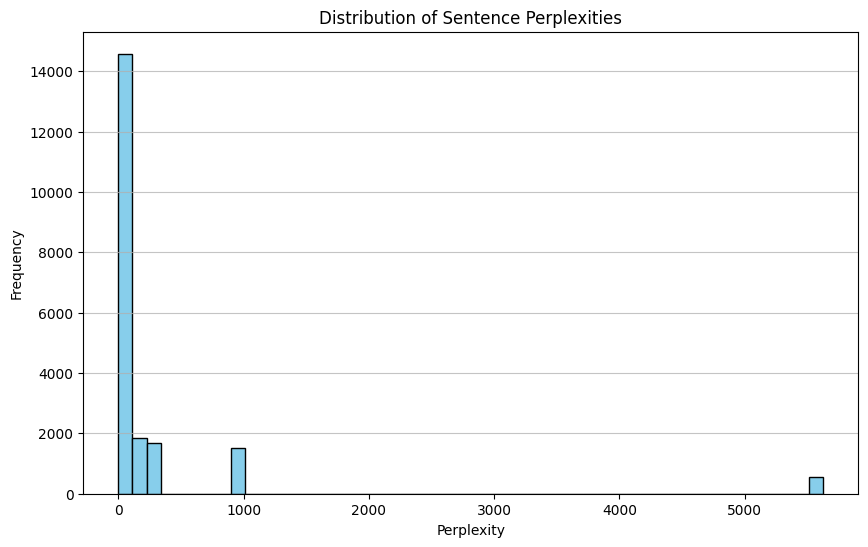

Witten-Bell average perplexity: 288.0239721248034
Witten-Bell median perplexity: 31.6227766016838


In [14]:
get_perp_plots(fullText, perpText, True)

|████████████████████████████████████████| 19115/19115 [100%] in 1.2s (15570.20/s) 


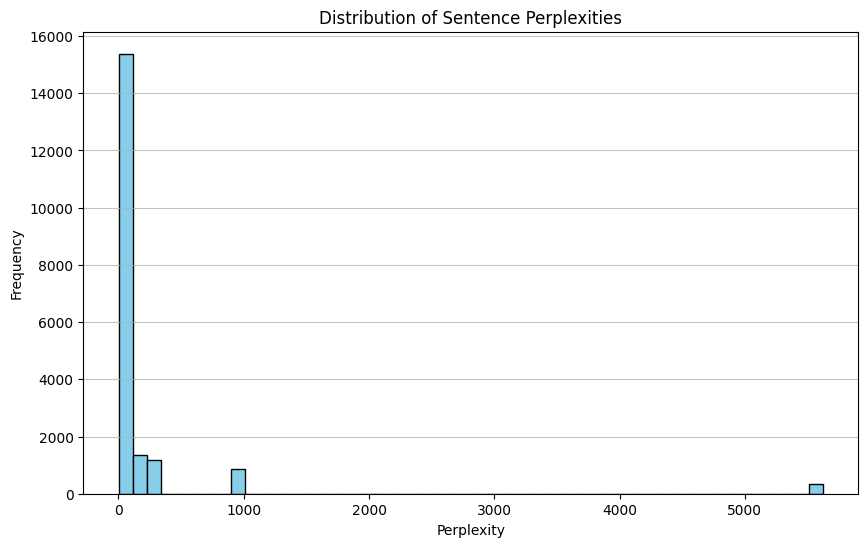

Witten-Bell average perplexity: 191.95386075441922
Witten-Bell median perplexity: 17.782794100389225


In [15]:
get_perp_plots(testText, testText, False)

## Binary Classification Task

In [16]:
# Take a mix of output and test sentences for binary classification task
## Take 10k output sentences and 10k test sentences randomly
output_sentences_bc = random.sample(output_sentences, 10000)
test_sentences_bc = random.sample(test_sentences, 10000)

# Create a binary classification dataset
binary_classification_dataset = output_sentences_bc + test_sentences_bc
binary_classification_labels = [1] * 10000 + [0] * 10000


In [17]:
class PerplexityDataset(Dataset):
    def __init__(self, sentences, labels, perplexity_function):
        self.sentences = sentences
        self.labels = labels
        self.perplexity_function = perplexity_function

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        perplexity_score = self.perplexity_function(sentence)
        return torch.tensor([perplexity_score], dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [19]:
# Create train and test loaders for the binary classification task
train_sentences, test_sentences, train_labels, test_labels = train_test_split(binary_classification_dataset, binary_classification_labels, test_size=0.2, random_state=42)

train_dataset = PerplexityDataset(train_sentences, train_labels, lambda x: perplexity(ngramDicts, x, 'wb'))
test_dataset = PerplexityDataset(test_sentences, test_labels, lambda x: perplexity(ngramDicts, x, 'wb'))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
class PerplexityClassifier(nn.Module):
    def __init__(self):
        super(PerplexityClassifier, self).__init__()
        self.classifier = nn.Linear(1, 2)

    def forward(self, x):
        return self.classifier(x)

In [21]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 10

# Initialize the model
classifier = PerplexityClassifier().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

/home2/autotune_vits/miniconda3/envs/nlp_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
def train_classifier(model, train_loader, criterion, optimizer, num_epochs=5):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [23]:
# Call the training function
train_classifier(classifier, train_loader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 0.7913
Epoch 2/10, Loss: 0.6965
Epoch 3/10, Loss: 0.6946
Epoch 4/10, Loss: 0.6941
Epoch 5/10, Loss: 0.6941
Epoch 6/10, Loss: 0.6939
Epoch 7/10, Loss: 0.6937
Epoch 8/10, Loss: 0.6942
Epoch 9/10, Loss: 0.6940
Epoch 10/10, Loss: 0.6937


In [24]:
def test(model, test_loader, criterion):
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs[:, 1].cpu().numpy())

    # Compute Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    mcc = matthews_corrcoef(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    print(f"Validation Loss: {total_loss / len(test_loader):.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"AUC: {roc_auc:.4f}")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Validation Loss: 0.6933
Accuracy: 49.53%
F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Matthews Correlation Coefficient: 0.0000
Confusion Matrix:
[[1981    0]
 [2019    0]]
AUC: 0.4928


/home2/autotune_vits/miniconda3/envs/nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


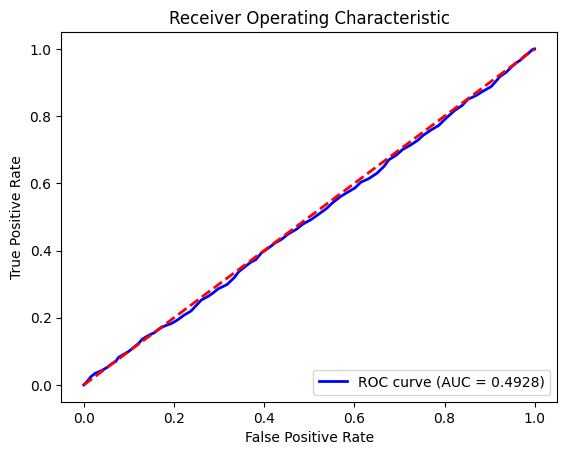

In [25]:
# Call the test function
test(classifier, test_loader, criterion)